## Transports of water along several cross-sections when only viscosity changes

Transports across several cross sections in the domain (See plot further down)

Water transport calculated as $\Phi_w = \vec{u}\cdot\vec{a}$

For all of these runs $K_v=10^{-5}$ $m^2s^{-1}$.

| Run |   $A_v$  ($m^2s^{-1}$)|
|-----| :---------------------: 
| 55  | $10^{-7}$ |
| 38  |   $10^{-5}$ |
| 56  |   $10^{-4}$ |
| 57  |  $10^{-3}$ |


In [1]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import scipy.io
import xarray as xr

In [2]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))

    waterCS_flux = (dx_CS*vel_CS).sum(dim=dim_name)

    return waterCS_flux

def calc_wat_transport_AS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_AS = (vel_component.isel(Y=y_slice, Xp1=x_slice))
    dx_AS = (spacing.isel(Y=y_slice, Xp1=x_slice))

    waterAS_flux = (dx_AS*vel_AS).sum(dim=dim_name)

    return waterAS_flux

def calc_wat_transport_Vert(vel_component, x_slice, y_slice,z_index, area):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.W)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_index : vertical index to set horizontal section
    area: xarray, area of each cell in the cross section (grid.rA)
    dim_name: str, name of the dimension along which to sum.
    
    RETURNS:
    Time series of vertical transport through the section.
    '''
    vel_vert = (vel_component.isel(Y=y_slice, X=x_slice, Zl=z_index))
    area_section = (area.isel(Y=y_slice, X=x_slice))

    waterVert_flux = ((area_section*vel_vert).sum(dim='Y')).sum(dim='X')

    return waterVert_flux

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('Water transport [$m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

In [4]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'

state_file55 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run55/stateGlob.nc'
state_file57 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run57/stateGlob.nc'
state_file56 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run56/stateGlob.nc'
state_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'

gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
state_file58 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run58/stateGlob.nc'
state_file60 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run60/stateGlob.nc'
state_file59 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run59/stateGlob.nc'
state_file42 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc'

grid = xr.open_dataset(grid_file)
state55 = xr.open_dataset(state_file55)
state57 = xr.open_dataset(state_file57)
state56 = xr.open_dataset(state_file56)
state38 = xr.open_dataset(state_file38)

gridNoC = xr.open_dataset(gridNoC_file)
state58 = xr.open_dataset(state_file58)
state60 = xr.open_dataset(state_file60)
state59 = xr.open_dataset(state_file59)
state42 = xr.open_dataset(state_file42)


### Cross-sections

In [5]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)


AS1_x_ind = 239


In [6]:
waterCS1_flux55 = calc_wat_transport_CS(unstagger_xarray(state55.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux55 = calc_wat_transport_CS(unstagger_xarray(state55.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux55 = calc_wat_transport_CS(unstagger_xarray(state55.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux55 = calc_wat_transport_CS(unstagger_xarray(state55.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux55 = calc_wat_transport_CS(unstagger_xarray(state55.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux57 = calc_wat_transport_CS(unstagger_xarray(state57.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux57 = calc_wat_transport_CS(unstagger_xarray(state57.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux57 = calc_wat_transport_CS(unstagger_xarray(state57.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux57 = calc_wat_transport_CS(unstagger_xarray(state57.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux57 = calc_wat_transport_CS(unstagger_xarray(state57.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux56 = calc_wat_transport_CS(unstagger_xarray(state56.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux56 = calc_wat_transport_CS(unstagger_xarray(state56.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux56 = calc_wat_transport_CS(unstagger_xarray(state56.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux56 = calc_wat_transport_CS(unstagger_xarray(state56.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux56 = calc_wat_transport_CS(unstagger_xarray(state56.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')


In [7]:
waterCS1_flux58 = calc_wat_transport_CS(unstagger_xarray(state58.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS2_flux58 = calc_wat_transport_CS(unstagger_xarray(state58.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS3_flux58 = calc_wat_transport_CS(unstagger_xarray(state58.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS4_flux58 = calc_wat_transport_CS(unstagger_xarray(state58.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS5_flux58 = calc_wat_transport_CS(unstagger_xarray(state58.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')

waterCS1_flux60 = calc_wat_transport_CS(unstagger_xarray(state60.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS2_flux60 = calc_wat_transport_CS(unstagger_xarray(state60.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS3_flux60 = calc_wat_transport_CS(unstagger_xarray(state60.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS4_flux60 = calc_wat_transport_CS(unstagger_xarray(state60.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS5_flux60 = calc_wat_transport_CS(unstagger_xarray(state60.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')

waterCS1_flux59 = calc_wat_transport_CS(unstagger_xarray(state59.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS2_flux59 = calc_wat_transport_CS(unstagger_xarray(state59.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS3_flux59 = calc_wat_transport_CS(unstagger_xarray(state59.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS4_flux59 = calc_wat_transport_CS(unstagger_xarray(state59.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS5_flux59 = calc_wat_transport_CS(unstagger_xarray(state59.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')

waterCS1_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS2_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS3_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS4_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')
waterCS5_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(gridNoC.dxG,'Yp1') , 'X')


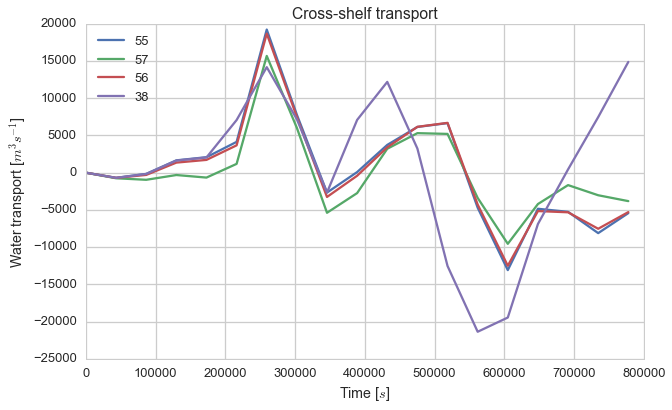

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterCS1_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterCS1_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterCS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 

ax = fig_looks(ax)

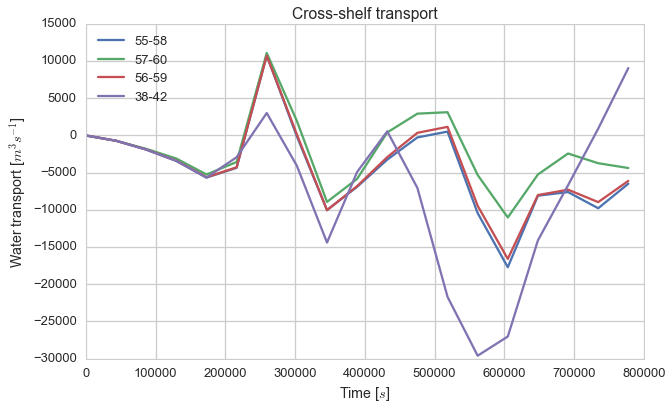

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS1_flux55-waterCS1_flux58)*grid.drF).sum(dim='Z').plot(ax=ax, label = '55-58')
((waterCS1_flux57-waterCS1_flux60)*grid.drF).sum(dim='Z').plot(ax=ax, label = '57-60')
((waterCS1_flux56-waterCS1_flux59)*grid.drF).sum(dim='Z').plot(ax=ax, label = '56-59')
((waterCS1_flux38-waterCS1_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = '38-42') 

ax = fig_looks(ax)

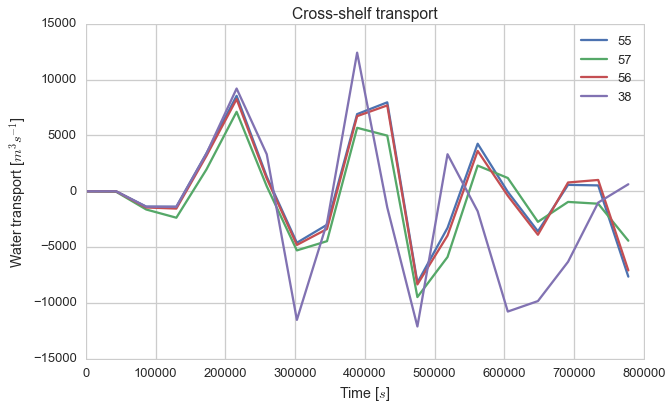

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS2_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterCS2_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterCS2_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterCS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

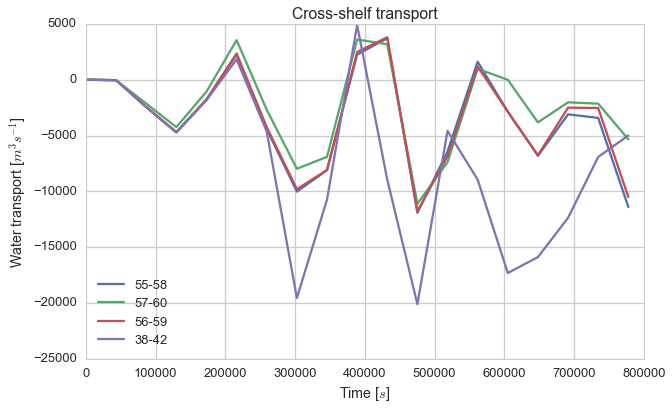

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS2_flux55-waterCS2_flux58)*grid.drF).sum(dim='Z').plot(ax=ax, label = '55-58')
((waterCS2_flux57-waterCS2_flux60)*grid.drF).sum(dim='Z').plot(ax=ax, label = '57-60')
((waterCS2_flux56-waterCS2_flux59)*grid.drF).sum(dim='Z').plot(ax=ax, label = '56-59')
((waterCS2_flux38-waterCS2_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = '38-42') 


ax = fig_looks(ax)

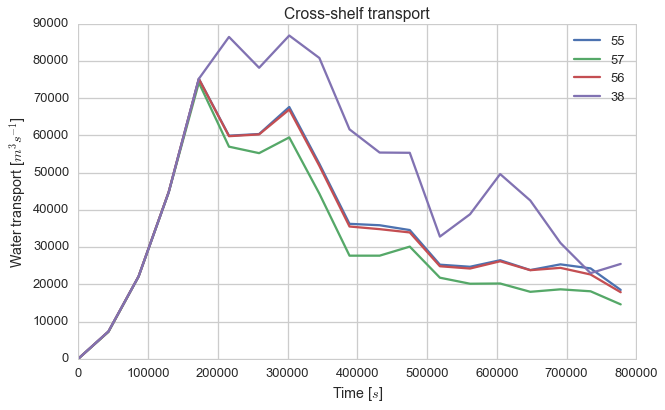

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS3_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterCS3_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterCS3_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterCS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

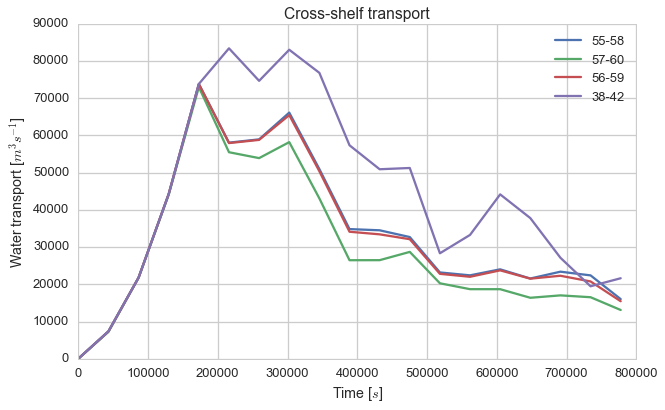

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS3_flux55-waterCS3_flux58)*grid.drF).sum(dim='Z').plot(ax=ax, label = '55-58')
((waterCS3_flux57-waterCS3_flux60)*grid.drF).sum(dim='Z').plot(ax=ax, label = '57-60')
((waterCS3_flux56-waterCS3_flux59)*grid.drF).sum(dim='Z').plot(ax=ax, label = '56-59')
((waterCS3_flux38-waterCS3_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = '38-42') 


ax = fig_looks(ax)

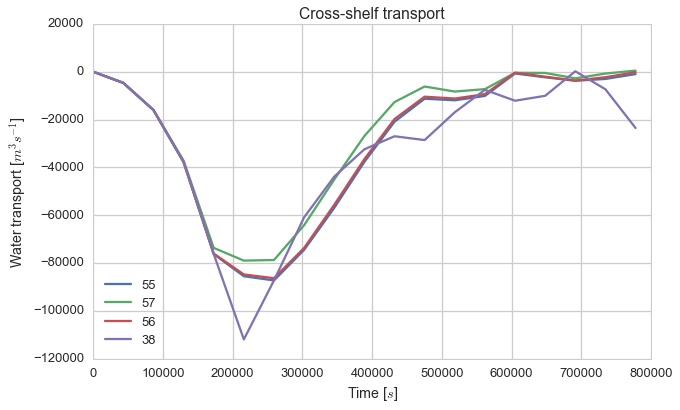

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS4_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterCS4_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterCS4_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterCS4_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)


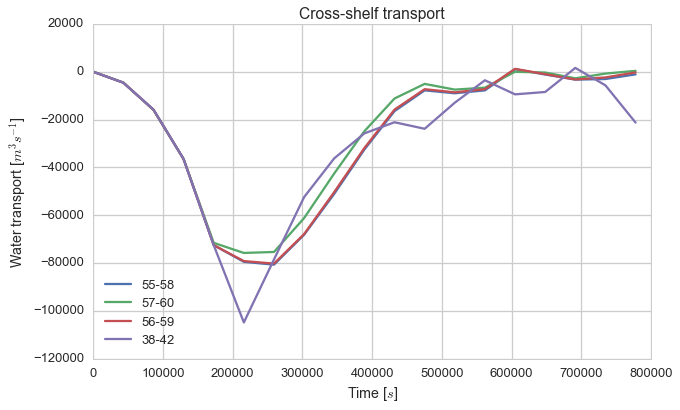

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS4_flux55-waterCS4_flux58)*grid.drF).sum(dim='Z').plot(ax=ax, label = '55-58')
((waterCS4_flux57-waterCS4_flux60)*grid.drF).sum(dim='Z').plot(ax=ax, label = '57-60')
((waterCS4_flux56-waterCS4_flux59)*grid.drF).sum(dim='Z').plot(ax=ax, label = '56-59')
((waterCS4_flux38-waterCS4_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = '38-42') 


ax = fig_looks(ax)


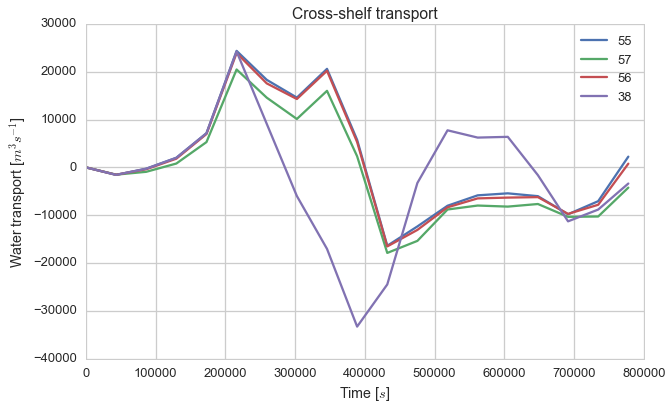

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS5_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterCS5_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterCS5_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterCS5_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

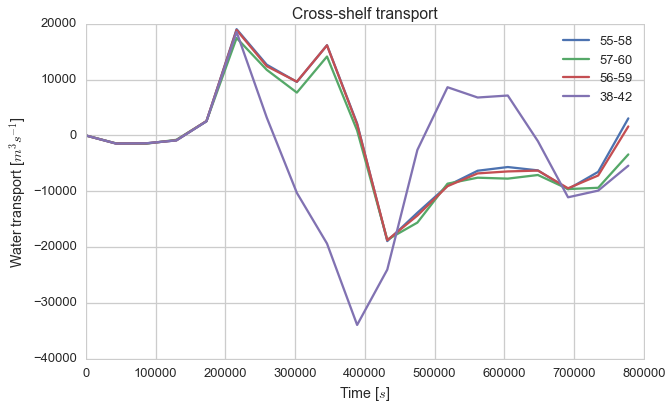

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS5_flux55-waterCS5_flux58)*grid.drF).sum(dim='Z').plot(ax=ax, label = '55-58')
((waterCS5_flux57-waterCS5_flux60)*grid.drF).sum(dim='Z').plot(ax=ax, label = '57-60')
((waterCS5_flux56-waterCS5_flux59)*grid.drF).sum(dim='Z').plot(ax=ax, label = '56-59')
((waterCS5_flux38-waterCS5_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = '38-42') 


ax = fig_looks(ax)

## Cross-shelf transport below 100 m

From 100m down


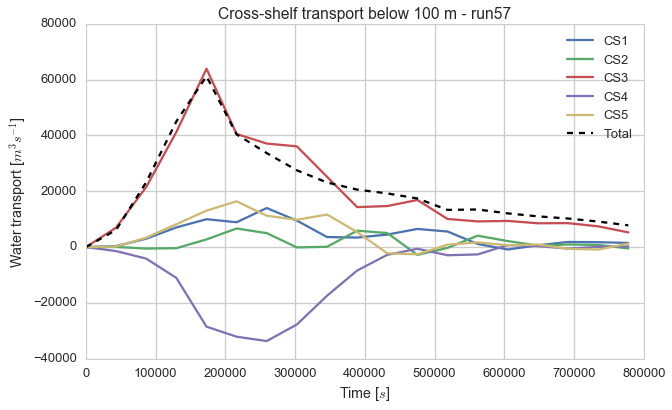

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux57*grid.drF+
 waterCS2_flux57*grid.drF+
 waterCS3_flux57*grid.drF+
 waterCS4_flux57*grid.drF+
 waterCS5_flux57*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('From 100m down')

ax = fig_looks(ax, title = 'Cross-shelf transport below 100 m - run57')

From 100m down


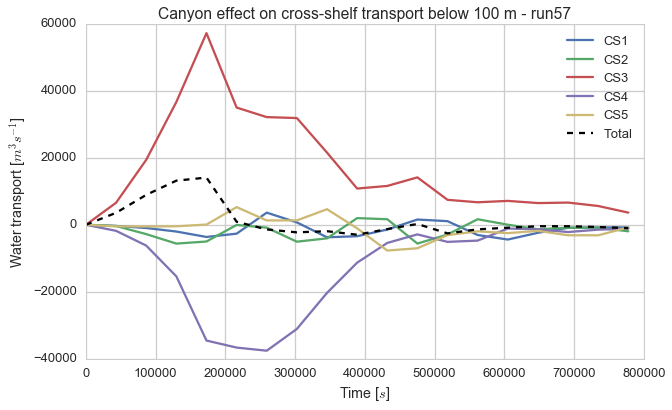

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS1_flux57-waterCS1_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
((waterCS2_flux57-waterCS2_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
((waterCS3_flux57-waterCS3_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
((waterCS4_flux57-waterCS4_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
((waterCS5_flux57-waterCS5_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

((waterCS1_flux57-waterCS1_flux60)*grid.drF+
 (waterCS2_flux57-waterCS2_flux60)*grid.drF+
 (waterCS3_flux57-waterCS3_flux60)*grid.drF+
 (waterCS4_flux57-waterCS4_flux60)*grid.drF+
 (waterCS5_flux57-waterCS5_flux60)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('From 100m down')

ax = fig_looks(ax, title = 'Canyon effect on cross-shelf transport below 100 m - run57')

From 100m down


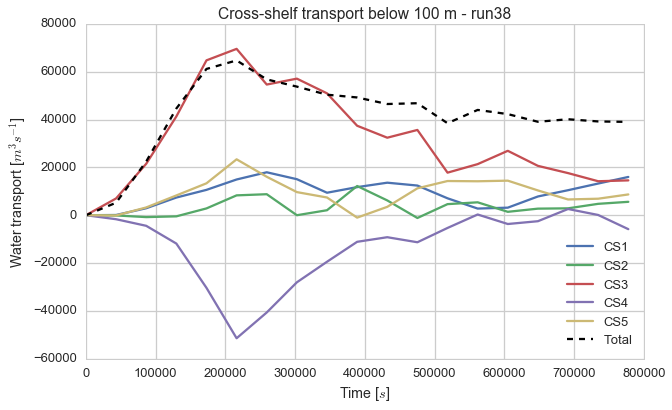

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux38*grid.drF+
 waterCS2_flux38*grid.drF+
 waterCS3_flux38*grid.drF+
 waterCS4_flux38*grid.drF+
 waterCS5_flux38*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('From 100m down')

ax = fig_looks(ax, title = 'Cross-shelf transport below 100 m - run38')

From 100m down


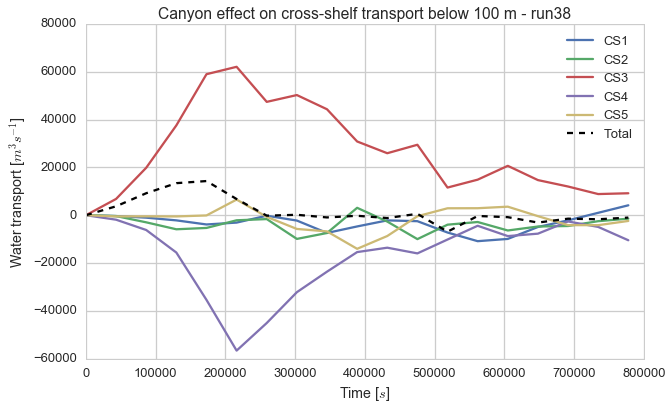

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

((waterCS1_flux38-waterCS1_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
((waterCS2_flux38-waterCS2_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
((waterCS3_flux38-waterCS3_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
((waterCS4_flux38-waterCS4_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
((waterCS5_flux38-waterCS5_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

((waterCS1_flux38-waterCS1_flux42)*grid.drF+
 (waterCS2_flux38-waterCS2_flux42)*grid.drF+
 (waterCS3_flux38-waterCS3_flux42)*grid.drF+
 (waterCS4_flux38-waterCS4_flux42)*grid.drF+
 (waterCS5_flux38-waterCS5_flux42)*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('From 100m down')

ax = fig_looks(ax, title = 'Canyon effect on cross-shelf transport below 100 m - run38')

## Alongshore transports

In [23]:

waterAS1_flux55 = calc_wat_transport_AS(unstagger_xarray(state55.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux55 = calc_wat_transport_AS(unstagger_xarray(state55.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux55 = calc_wat_transport_AS(unstagger_xarray(state55.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux57 = calc_wat_transport_AS(unstagger_xarray(state57.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux57 = calc_wat_transport_AS(unstagger_xarray(state57.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux57 = calc_wat_transport_AS(unstagger_xarray(state57.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux56 = calc_wat_transport_AS(unstagger_xarray(state56.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux56 = calc_wat_transport_AS(unstagger_xarray(state56.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux56 = calc_wat_transport_AS(unstagger_xarray(state56.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')



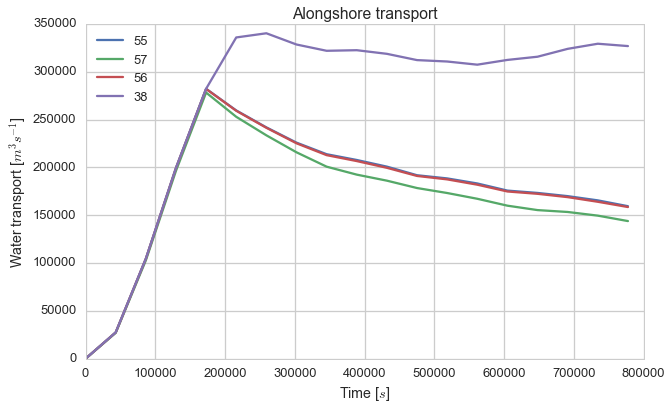

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterAS1_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterAS1_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterAS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')

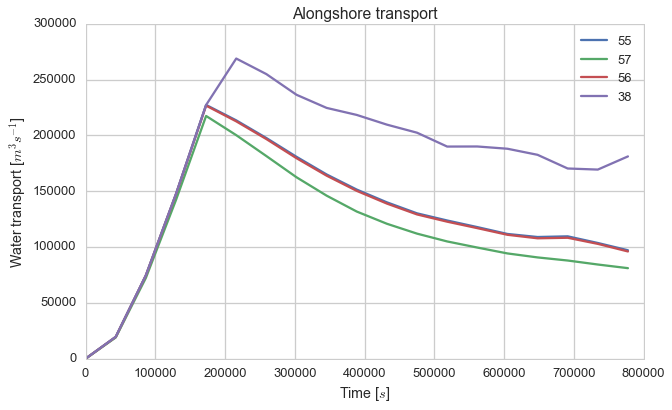

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS2_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterAS2_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterAS2_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterAS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')

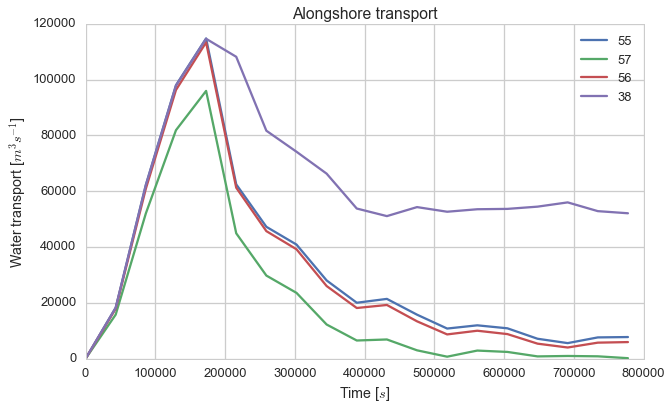

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS3_flux55*grid.drF).sum(dim='Z').plot(ax=ax, label = '55')
(waterAS3_flux57*grid.drF).sum(dim='Z').plot(ax=ax, label = '57')
(waterAS3_flux56*grid.drF).sum(dim='Z').plot(ax=ax, label = '56')
(waterAS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')

## Vertical transports

In [27]:
hor_section_x = slice(120,240)
hor_section_y = slice(227,267)
z_index = 30

waterVert_flux38 = calc_wat_transport_Vert(state38.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux55 = calc_wat_transport_Vert(state55.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux56 = calc_wat_transport_Vert(state56.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux57 = calc_wat_transport_Vert(state57.W, hor_section_x, hor_section_y,z_index, grid.rA)

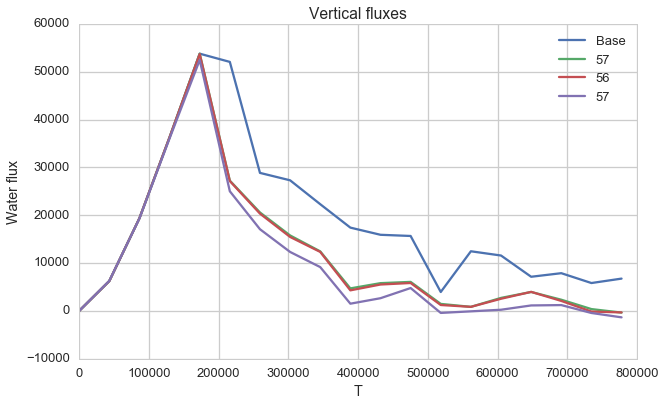

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterVert_flux38).plot(ax=ax, label = 'Base')
(waterVert_flux55).plot(ax=ax, label = '57')
(waterVert_flux56).plot(ax=ax, label = '56')
(waterVert_flux57).plot(ax=ax, label = '57')

ax.set_ylabel('Water flux')
ax.legend(loc=0)
ax.set_title('Vertical fluxes')
